In [4]:
import pandas as pd
import numpy as np

import os

In [5]:
# Define the relative path to the CSV file
file_path = '../data_with_state.csv'

# Read the CSV file
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()


,lat,lon,time,gws_inst,rtzsm_inst,sfsm_inst,start_date,end_date,week_no,STATE
0,12.375,92.875,02-01-2023,18.191570,12.279556,14.335435,02-01-2023,08-01-2023,4.0,ANDAMAN AND NICOBAR ISLANDS
1,12.625,92.875,02-01-2023,23.398462,18.300697,20.701302,02-01-2023,08-01-2023,4.0,ANDAMAN AND NICOBAR ISLANDS
2,12.375,92.875,09-01-2023,17.314518,9.416865,11.187888,09-01-2023,15-01-2023,21.0,ANDAMAN AND NICOBAR ISLANDS
3,12.625,92.875,09-01-2023,23.560562,11.538414,13.080875,09-01-2023,15-01-2023,21.0,ANDAMAN AND NICOBAR ISLANDS
4,12.375,92.875,16-01-2023,16.458113,14.406377,18.757080,16-01-2023,22-01-2023,38.0,ANDAMAN AND NICOBAR ISLANDS


In [6]:
data.dtypes

lat           float64
lon           float64
time           object
gws_inst      float64
rtzsm_inst    float64
sfsm_inst     float64
start_date     object
end_date       object
week_no       float64
STATE          object
dtype: object

In [7]:
# display shape
data.shape

(341810, 10)

In [9]:
data['STATE'].unique()

array(['ANDAMAN AND NICOBAR ISLANDS', 'ANDHRA PRADESH',
       'ARUNACHAL PRADESH', 'ASSAM', 'BIHAR', 'CHANDIGARH',
       'DADRA AND NAGAR HAVELI', 'DAMAN AND DIU', 'DELHI', 'GOA',
       'GUJARAT', 'HARYANA', 'HIMACHAL PRADESH', 'JAMMU AND KASHMIR',
       'KARNATAKA', 'KERALA', 'LAKSHADWEEP', 'MADHYA PRADESH',
       'MAHARASHTRA', 'MANIPUR', 'MEGHALAYA', 'MIZORAM', 'NAGALAND',
       'ORISSA', 'PONDICHERRY', 'PUNJAB', 'RAJASTHAN', 'SIKKIM',
       'TAMIL NADU', 'TRIPURA', 'UTTAR PRADESH', 'WEST BENGAL'],
      dtype=object)

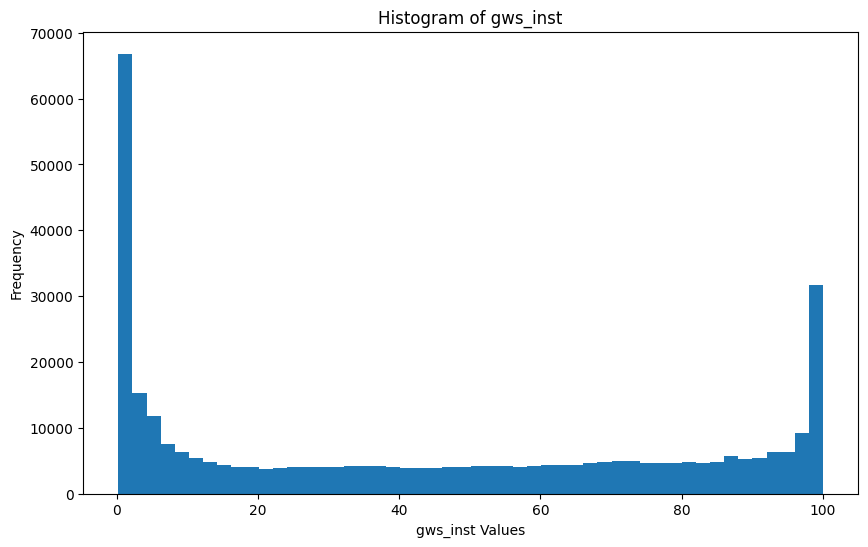

In [12]:
import matplotlib.pyplot as plt

data['gws_inst'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title("Histogram of gws_inst")
plt.xlabel('gws_inst Values')
plt.show()


In [13]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['gws_inst'].quantile(0.25)
Q3 = data['gws_inst'].quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['gws_inst'] < lower_bound) | (data['gws_inst'] > upper_bound)]

# Display the outliers
print(f"Number of outliers detected: {len(outliers)}")
outliers


Number of outliers detected: 0


,lat,lon,time,gws_inst,rtzsm_inst,sfsm_inst,start_date,end_date,week_no,STATE


<Axes: ylabel='Frequency'>

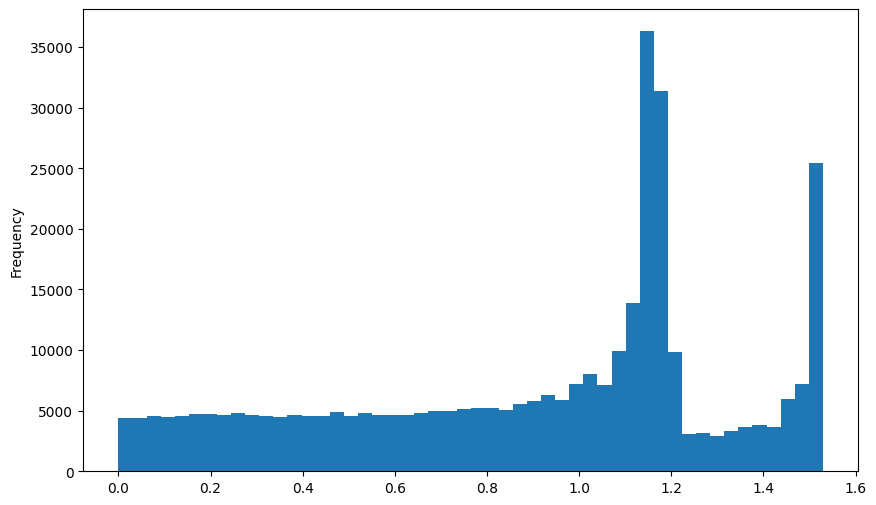

In [16]:
from scipy import stats
import numpy as np

# Calculate Z-scores for the 'gws_inst' column
z_scores = np.abs(stats.zscore(data['gws_inst'].dropna()))  # Drop NA values before calculating Z-scores


z_scores.plot(kind='hist', bins=50, figsize=(10, 6))

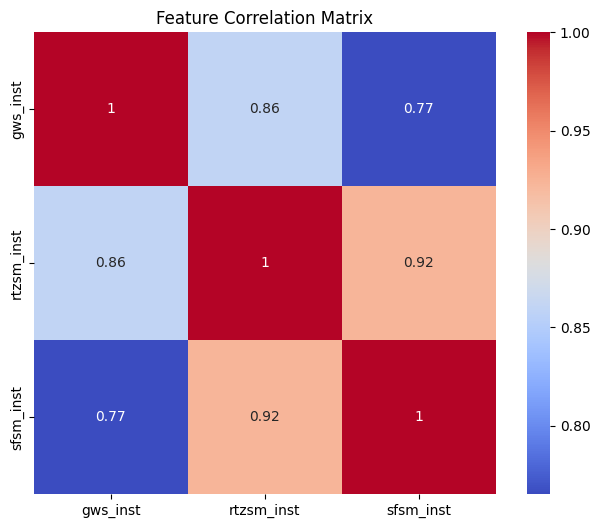

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data'
# Compute the correlation matrix
correlation_matrix = data[['gws_inst', 'rtzsm_inst', 'sfsm_inst']].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('../data_with_state.csv')

# Convert the 'time' column to datetime
data['time'] = pd.to_datetime(data['time'], format='%d-%m-%Y')


# Sort the data by time
data = data.sort_values('time')

# Select the relevant features for the time-series analysis
features = ['lat', 'lon', 'rtzsm_inst', 'sfsm_inst', 'week_no']
target = 'gws_inst'

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])


# Create sequences for LSTM (let's use 30 timesteps)
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]  # all features except target
        y = data[i+seq_length, -1]  # target column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
SEQ_LENGTH = 30  # Number of past time steps to consider
X, y = create_sequences(data_scaled, SEQ_LENGTH)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout
model.add(LSTM(units=64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))

# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))




c:\Users\senna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 321s 74ms/step - loss: 0.0561 - val_loss: 0.0414
Epoch 2/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 284s 66ms/step - loss: 0.0424 - val_loss: 0.0380
Epoch 3/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 317s 65ms/step - loss: 0.0390 - val_loss: 0.0365
Epoch 4/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 308s 62ms/step - loss: 0.0370 - val_loss: 0.0366
Epoch 5/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 277s 65ms/step - loss: 0.0358 - val_loss: 0.0349
Epoch 6/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 293s 69ms/step - loss: 0.0345 - val_loss: 0.0329
Epoch 7/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 296s 69ms/step - loss: 0.0330 - val_loss: 0.0307
Epoch 8/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 206s 48ms/step - loss: 0.0317 - val_loss: 0.0300
Epoch 9/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 198s 46ms/step - loss: 0.0304 - val_loss: 0.0288
Epoch 10/10
4273/4273 ━━━━━━━━━━━━━━━━━━━━ 203s 46ms/step - loss: 0.0292 - val_loss: 0.0270


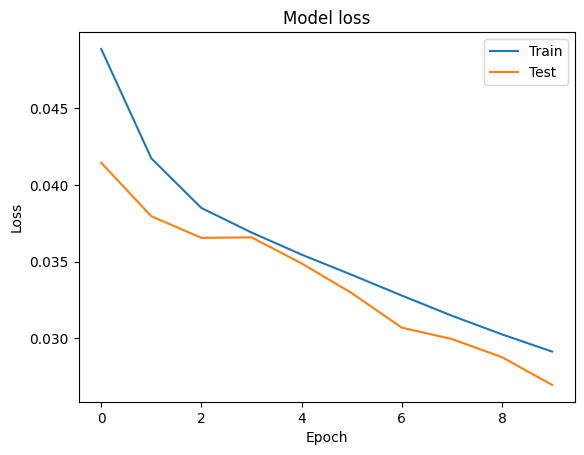

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [14]:
# Make predictions
predictions = model.predict(X_test)

# Rescale the predictions back to original values
y_test_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), X_test.shape[2])), y_test.reshape(-1,1)], axis=1))[:, -1]
predictions_rescaled = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), X_test.shape[2])), predictions], axis=1))[:, -1]



2137/2137 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step


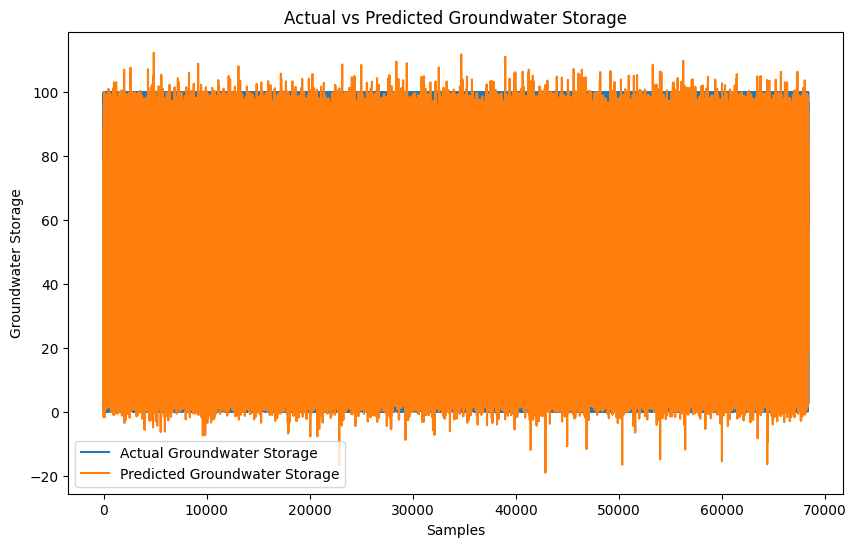

In [15]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Groundwater Storage')
plt.plot(predictions_rescaled, label='Predicted Groundwater Storage')
plt.title('Actual vs Predicted Groundwater Storage')
plt.xlabel('Samples')
plt.ylabel('Groundwater Storage')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 11.076786681904332
Mean Squared Error (MSE): 268.4847941445523
Root Mean Squared Error (RMSE): 16.385505611501657


In [18]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_rescaled, predictions_rescaled)
print("R² Score:", r2)


R² Score: 0.8002393546801861


In [19]:
# Number of samples
n = len(y_test_rescaled)

p=1

# Calculate Adjusted R²
adjusted_r2 = 1 - ((1 - r2) * (n - 1)) / (n - p - 1)
adjusted_r2

0.8002364322375299